In [1]:
import dgl.nn as dglnn
import dgl
import math
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from collections import defaultdict
import gc
import os
import torch.nn.init as init
from dgl.nn import GATConv
from dgl.nn.functional import edge_softmax

In [2]:
data = pd.read_csv('NF-BoT-IoT-v2.csv')

In [3]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,192.168.100.7,80,192.168.100.149,40341,6,7.0,44,1,180,2,...,5840,512,0,0,0,0,0,0,0,Benign
1,192.168.100.3,80,192.168.100.150,38871,6,7.0,44,1,320,3,...,29200,512,0,0,0,0,0,0,0,Benign
2,192.168.100.6,80,192.168.100.148,34243,6,7.0,40,1,280,2,...,0,512,0,0,0,0,0,0,0,Benign
3,192.168.100.3,80,192.168.100.147,53060,6,7.0,44,1,180,2,...,29200,512,0,0,0,0,0,0,0,Benign
4,192.168.100.3,80,192.168.100.149,43333,6,7.0,44,1,180,2,...,29200,512,0,0,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113286,192.168.100.3,0,192.168.100.150,0,1,0.0,168,3,0,0,...,0,0,771,3,0,0,0,0,1,Theft
113287,192.168.100.3,54889,192.168.100.149,4433,6,0.0,60,1,40,1,...,29200,0,0,0,0,0,0,0,1,Theft
113288,192.168.100.150,0,192.168.100.3,0,1,0.0,360,4,0,0,...,0,0,4352,17,0,0,0,0,1,Theft
113289,192.168.100.3,54874,192.168.100.149,4433,6,0.0,60,1,40,1,...,29200,0,0,0,0,0,0,0,1,Theft


In [4]:
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
#data

In [5]:
len(data.Attack.value_counts())

5

In [6]:
data.Attack.unique()

array(['Benign', 'DDoS', 'DoS', 'Reconnaissance', 'Theft'], dtype=object)

In [7]:
data.drop(columns=['Label'],inplace = True)
data.rename(columns={"Attack": "label"},inplace = True)
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])
label = data.label
data.drop(columns=['label'],inplace = True)
scaler = StandardScaler()
#scaler = MinMaxScaler()
data =  pd.concat([data, label], axis=1)
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,label
0,192.168.100.7:80,172.19.186.36:40341,6,7.0,44,1,180,2,22,18,...,0,5840,512,0,0,0,0,0,0,0
1,192.168.100.3:80,172.20.54.172:38871,6,7.0,44,1,320,3,22,18,...,0,29200,512,0,0,0,0,0,0,0
2,192.168.100.6:80,172.22.143.132:34243,6,7.0,40,1,280,2,22,20,...,0,0,512,0,0,0,0,0,0,0
3,192.168.100.3:80,172.19.232.222:53060,6,7.0,44,1,180,2,22,18,...,0,29200,512,0,0,0,0,0,0,0
4,192.168.100.3:80,172.17.203.122:43333,6,7.0,44,1,180,2,22,18,...,0,29200,512,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113286,192.168.100.3:0,172.18.76.103:0,1,0.0,168,3,0,0,0,0,...,0,0,0,771,3,0,0,0,0,4
113287,192.168.100.3:54889,172.27.180.176:4433,6,0.0,60,1,40,1,22,2,...,0,29200,0,0,0,0,0,0,0,4
113288,192.168.100.150:0,172.23.100.104:0,1,0.0,360,4,0,0,0,0,...,0,0,0,4352,17,0,0,0,0,4
113289,192.168.100.3:54874,172.20.80.106:4433,6,0.0,60,1,40,1,22,2,...,0,29200,0,0,0,0,0,0,0,4


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data,label, test_size=0.3, random_state=123,stratify= label)

In [9]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [10]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

X_train['h'] = X_train[ cols_to_norm ].values.tolist()
#X_train

In [11]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [12]:
class GATlayer(nn.Module):
    def __init__(self, n_feat, e_feat, out_feat, num_heads):
        super(GATlayer,self).__init__()
    
        self.n_feat = n_feat
        self.e_feat = e_feat
        self.out_feat = out_feat
        self.num_heads = num_heads
        self.W_msg = nn.Linear(2 * n_feat + e_feat, out_feat)
        self.W = nn.Linear(2 * n_feat + e_feat, 2 * out_feat)
 
        self.a = nn.Parameter(torch.rand(size=(2 * out_feat  , 1)))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        
        gain = math.sqrt(2)
        init.xavier_normal_(self.W.weight, gain=gain)

        init.xavier_normal_(self.a, gain=gain)
    
    def edge_attention(self, edges):        
        
        feat_cat = torch.cat([edges.src['h'], edges.dst['h'], edges.data['h']], dim=1)
        
        w_feat_cat = self.W(feat_cat)
                
        #e = F.leaky_relu(torch.matmul(w_feat_cat, self.a[i]))
                              
        return {'e': F.leaky_relu(torch.matmul(w_feat_cat, self.a))}
        
#     def message_func(self, edges):
#         return {'h': self.W_msg(torch.cat([edges.src['h'], edges.dst['h'], edges.data['h']], dim=1)) , 'e': edges.data['e']}
    
    def message_func(self, edges):
        return {'h': self.W_msg(torch.cat([edges.src['h'], edges.dst['h'], edges.data['h']], dim=1)) , 'x': edges.data['x']}
  
    
    def reduce_func(self, nodes):
        
#         attention = F.softmax(nodes.mailbox['e'] ,dim = 1)
#         h = (attention * nodes.mailbox['h']).sum(1)
        h = (nodes.mailbox['x'] * nodes.mailbox['h']).sum(1)
        return {'h': h}
    
    def forward(self, g, n_feat, e_feat):
        with g.local_scope():
            
            g.ndata['h'] = n_feat
            
            g.edata['h'] = e_feat
            g.apply_edges(self.edge_attention)
            #attention = edge_softmax(g, edges.data['e'] ,norm_by='src')
            attention = edge_softmax(g, g.edata['e'])
            g.edata['x'] = attention
            g.update_all(self.message_func, self.reduce_func)
            g.ndata['h'] = F.relu(g.ndata['h'])
            feat = g.ndata['h']
                
            return feat
        
class MultiHeadGATLayer(nn.Module):
    def __init__(self, n_feat, e_feat, out_feat, num_heads):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATlayer(n_feat, e_feat, out_feat, num_heads))
        
    def forward(self,g, h, e_feat):
        
        out_feat = [attn_head(g, h, e_feat) for attn_head in self.heads]
    
        out_feat = torch.cat(out_feat,dim = 1).reshape(g.num_nodes(),len(self.heads), -1)

        return out_feat.mean(1)

class GAT(nn.Module):
    def __init__(self, in_dim, e_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer( in_dim, e_dim, 39, num_heads)
#         self.layer1 = MultiHeadGATLayer( in_dim, e_dim, 16, num_heads)
#         self.layer2 = MultiHeadGATLayer( 16, e_dim, out_dim, 1)
        
    def forward(self, g, h, e_feat):
        h = self.layer1(g, h, e_feat)
#         h = F.dropout(h,p = 0.2)
#         h = self.layer2(g, h, e_feat)
        g.ndata['h'] = h
        return h , g

In [13]:
class Genetation(torch.nn.Module):
    def __init__(self, in_feat, out_feat, num_heads, activation):
        super(Genetation, self).__init__()
        self.conv = GATConv(in_feat, out_feat, num_heads)
        self.activation = activation

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, g, feat):
        x = self.activation(self.conv(g, feat))
        #x = self.conv(g, feat)
        g.ndata['h'] = x
        return x.mean(1) ,g

In [14]:
import random
def sub_sam(nodes, adj_lists, k):
    node_neighbor =  [ [] for i in range(nodes.shape[0])]
    node_neighbor_cen =  [ [] for i in range(nodes.shape[0])]
    node_centorr =  [[] for i in range(nodes.shape[0])]

    num_nei = 0

    for node in nodes:
        neighbors = set([int(node)])
        neighs = adj_lists[int(node)]
        node_centorr[num_nei] = [int(node)]
        current1 = adj_lists[int(node)]
        if len(neighs) >= k:
            neighs -= neighbors
            current1 = random.sample(neighs, k-1)

            node_neighbor[num_nei] = [neg_node for neg_node in current1]
            current1.append(int(node))
            node_neighbor_cen[num_nei] = [neg_node for neg_node in current1]
            num_nei += 1

        node_neighbor_cen[num_nei] = [neg_node for neg_node in current1]

    node_neighbor_cen = [neighbors for neighbors in node_neighbor_cen if neighbors]
    node_neighbor_cen  = node_neighbor_cen[:-1]
    return node_neighbor_cen

In [15]:
class Model(nn.Module):
    def __init__(self,  Encoder, gene, tau = 0.5):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.tau: float = tau
        self.ge = gene

    def forward(self, graph, node_feats, edge_feats) :
        z, g1 = self.encoder(graph,node_feats,edge_feats)
        #z_g, g2 = self.ge(graph,z)
        z_g, g2 = self.ge(graph,z,edge_feats)
        return z, z_g, g1, g2
    
    def embed(self, graph, node_feats, edge_feats):
        z,_ = self.encoder(graph, node_feats, edge_feats)
        return z

    def loss(self, z1, z2, adj, sub_g1, g1, g2):
        loss = self.sub_loss_batch(z1, z2, adj, sub_g1, g1, g2)
        return loss

    def sub_loss_batch(self, z, z_g, adj, sub_g1, g1, g2):
        subz_s, sub_gene_s = self.subg_centor(z, z_g, sub_g1)

        num = th.randint(0, len(sub_g1)-1, [len(sub_g1),])
        if num[0] == 0:
            num[0] = 1
        for i in range(1, len(num)):
            if num[i] == i:
                num[i] -= 1
        subg2_s_n = subz_s[num] # disrupt
        sub_gene_s_n = sub_gene_s[num]
        #print('sub_gene_s',sub_gene_s.shape)
        #print('sub_gene_s_n',sub_gene_s_n.shape)

        input1 = th.cat((subz_s, subz_s, subz_s), dim=0)
        input2 = th.cat((sub_gene_s, subg2_s_n, sub_gene_s_n), dim=0)
        
        edges1, edges2 = self.edges_f(g1, g2, sub_g1, z, z_g)
        #print('edges2',edges2.shape)
        subg2_se = edges1[num]
        sub_gene_s_e = edges2[num]
        #print('sub_gene_s_e',sub_gene_s_e.shape)
        input1_edges = th.cat((edges1, edges1, edges1), dim=0)
        input2_edges = th.cat((edges2, subg2_se, sub_gene_s_e), dim=0)
        input1_edges = input1_edges.requires_grad_(True)
        input2_edges = input2_edges.requires_grad_(True)
        
        # adj
        subg1_adj = self.sub_adj(adj, sub_g1)
        input_adj = th.cat((subg1_adj, subg1_adj, subg1_adj), dim=0)
        
        lbl_1 = th.ones(len(sub_g1)).cuda()
        lbl_2 = th.zeros(len(sub_g1)*2).cuda()
        lbl = th.cat((lbl_1, lbl_2), 0).cuda()
        
        lbl_1_e = th.ones(len(edges2) ).cuda()
        lbl_2_e = th.zeros(len(edges2)* 2).cuda()
        lbl_e = th.cat((lbl_1_e, lbl_2_e), 0).cuda()
        
         # WD
        wd, T_wd = self.wd(input1, input2, self.tau)
        logits = th.exp(-wd / 0.01)
        loss1 = b_xent(th.squeeze(logits), lbl)
        print('loss1', loss1)
        
        # GWD
        gwd = self.gwd(input1.transpose(2,1), input2.transpose(2,1), T_wd, input_adj, self.tau)
        logits2 = th.exp(-gwd / 0.1)
        loss2 = b_xent(th.squeeze(logits2), lbl)
        print('loss2',loss2)
        

        wd, T_wd = self.wd(input1_edges, input2_edges, self.tau)
        logits3 = th.exp(-wd / 0.01)
        loss3 = b_xent(th.squeeze(logits3), lbl_e)
        print('loss3', loss3)


        loss = 0.5 * loss3 + 0.5 * loss2
        #loss = 0.6 * loss3 + 0.4 * loss1 
        return loss
    
    def edges_f (self,g1,g2,sub_g1, z, z_g):
        edge_feat_1 = [[] for i in range(len(sub_g1))]
        edge_feat_2 = [[] for i in range(len(sub_g1))]
        sc = MLPPredictor(g1.edata['h'].shape[1],39).cuda()
        z_e = sc(g1, z)
        z_ge = sc(g2, z_g)
        for i in range(len(sub_g1)):
            cen_node = sub_g1[i][-1]
            dst = sub_g1[i][:-1]
            src_node_id = cen_node

            for j in dst:
                dst_node_id = j

                edge_indices = g1.edge_ids(src_node_id, dst_node_id,return_uv = True)

                edge_feature_1 = torch.Tensor(z_e[edge_indices[2]]).float().tolist()
                edge_feature_2 = torch.Tensor(z_ge[edge_indices[2]]).float().tolist()

                edge_feat_1.append(edge_feature_1)
                edge_feat_2.append(edge_feature_2)
                if len(edge_feat_1[-1]) == 2:
                    edge_feat_1[-1] = [edge_feat_1[-1][0]]
                    edge_feat_2[-1] = [edge_feat_2[-1][0]]
                
        edge_feat_1 = [neighbors for neighbors in edge_feat_1 if neighbors]
        edge_feat_2 = [neighbors for neighbors in edge_feat_2 if neighbors]
        edge_feat_1 = torch.Tensor(edge_feat_1)
#         print('edge_feat_1',edge_feat_1)
        edge_feat_2 = torch.Tensor(edge_feat_2)
        edge_feat_1 = edge_feat_1.reshape(len(sub_g1),-1, 39)
        edge_feat_2 = edge_feat_2.reshape(len(sub_g1),-1, 39)
        return edge_feat_1, edge_feat_2
    
    def sub_adj(self, adj, sub_g1):
        subg1_adj = th.zeros(len(sub_g1), len(sub_g1[0]), len(sub_g1[0]))
        for i in range(len(sub_g1)):
            subg1_adj[i] = adj[sub_g1[i]].t()[sub_g1[i]]
        return subg1_adj


    def subg_centor(self, z, z_g, sub_g1):
        sub = [element for lis in sub_g1 for element in lis]
        subz = z[sub] 
        subg = z_g[sub]

        sub_s = subz.reshape(len(sub_g1), len(sub_g1[0]), -1)
        subg_s = subg.reshape(len(sub_g1), len(sub_g1[0]), -1)
        return sub_s, subg_s

    # WD
    def wd(self, x, y, tau):
        cos_distance = self.cost_matrix_batch(th.transpose(x, 2, 1), th.transpose(y, 2, 1), tau)
        cos_distance = cos_distance.transpose(1,2)

        beta = 0.1
        min_score = cos_distance.min()
        max_score = cos_distance.max()
        threshold = min_score + beta * (max_score - min_score)
        cos_dist = nn.functional.relu(cos_distance - threshold)
        
        wd, T_wd = self.OT_distance_batch(cos_dist, x.size(0), x.size(1), y.size(1), 40)
        return wd, T_wd

    def OT_distance_batch(self, C, bs, n, m, iteration=50):
        C = C.float().cuda()
        T = self.OT_batch(C, bs, n, m, iteration=iteration)
        temp = th.bmm(th.transpose(C,1,2), T)
        distance = self.batch_trace(temp, m, bs)
        return distance, T
    
    def OT_batch(self, C, bs, n, m, beta=0.5, iteration=50):
        sigma = th.ones(bs, int(m), 1).cuda()/float(m)
        T = th.ones(bs, n, m).cuda()
        A = th.exp(-C/beta).float().cuda()
        for t in range(iteration):
            Q = A * T
            for k in range(1):
                delta = 1 / (n * th.bmm(Q, sigma))
                a = th.bmm(th.transpose(Q,1,2), delta)
                sigma = 1 / (float(m) * a)
            T = delta * Q * sigma.transpose(2,1)
        return T

    def cost_matrix_batch(self, x, y, tau=0.5):
        bs = list(x.size())[0]
        D = x.size(1)
        assert(x.size(1)==y.size(1))
        x = x.contiguous().view(bs, D, -1)
        x = x.div(th.norm(x, p=2, dim=1, keepdim=True) + 1e-12)
        y = y.div(th.norm(y, p=2, dim=1, keepdim=True) + 1e-12)
        
        cos_dis = th.bmm(th.transpose(x, 1, 2), y)
        cos_dis = th.exp(- cos_dis / tau)
        return cos_dis.transpose(2,1)

    def batch_trace(self, input_matrix, n, bs):
        a = th.eye(n).cuda().unsqueeze(0).repeat(bs, 1, 1)
        b = a * input_matrix
        return th.sum(th.sum(b,-1),-1).unsqueeze(1)
    
    
    # GWD
    def gwd(self, X, Y, T_wd, input_adj, tau, lamda=1e-1, iteration=5, OT_iteration=20):
        m = X.size(2)
        n = Y.size(2)
        bs = X.size(0)
        p = (th.ones(bs, m, 1)/m).cuda()
        q = (th.ones(bs, n, 1)/n).cuda()
        return self.GW_distance(X, Y, p, q, T_wd, input_adj, tau, lamda=lamda, iteration=iteration, OT_iteration=OT_iteration)

    def GW_distance(self, X, Y, p, q, T_wd, input_adj, tau, lamda=0.5, iteration=5, OT_iteration=20):
        cos_dis = th.exp(- input_adj / tau).cuda() 
        beta = 0.1
        min_score = cos_dis.min()
        max_score = cos_dis.max()
        threshold = min_score + beta * (max_score - min_score)
        res = cos_dis - threshold
        Cs = nn.functional.relu(res.transpose(2,1))

        Ct = self.cos_batch(Y, Y, tau).float().cuda()
        bs = Cs.size(0)
        m = Ct.size(2)
        n = Cs.size(2)
        T, Cst = self.GW_batch(Cs, Ct, bs, n, m, p, q, beta=lamda, iteration=iteration, OT_iteration=OT_iteration)
        temp = th.bmm(th.transpose(Cst,1,2), T_wd)
        distance = self.batch_trace(temp, m, bs)
        return distance

    def GW_batch(self, Cs, Ct, bs, n, m, p, q, beta=0.5, iteration=5, OT_iteration=20):
        one_m = th.ones(bs, m, 1).float().cuda()
        one_n = th.ones(bs, n, 1).float().cuda()

        Cst = th.bmm(th.bmm(Cs**2, p), th.transpose(one_m, 1, 2)) + \
            th.bmm(one_n, th.bmm(th.transpose(q,1,2), th.transpose(Ct**2, 1, 2)))
        gamma = th.bmm(p, q.transpose(2,1))
        for i in range(iteration):
            C_gamma = Cst - 2 * th.bmm(th.bmm(Cs, gamma), th.transpose(Ct, 1, 2))
            gamma = self.OT_batch(C_gamma, bs, n, m, beta=beta, iteration=OT_iteration)
        Cgamma = Cst - 2 * th.bmm(th.bmm(Cs, gamma), th.transpose(Ct, 1, 2))
        return gamma.detach(), Cgamma

    def cos_batch(self, x, y, tau):
        bs = x.size(0)
        D = x.size(1)
        assert(x.size(1)==y.size(1))
        x = x.contiguous().view(bs, D, -1)
        x = x.div(th.norm(x, p=2, dim=1, keepdim=True) + 1e-12)
        y = y.div(th.norm(y, p=2, dim=1, keepdim=True) + 1e-12)
        cos_dis = th.bmm(th.transpose(x,1,2), y)
        cos_dis = th.exp(- cos_dis / tau).transpose(1,2)
        
        beta = 0.1
        min_score = cos_dis.min()
        max_score = cos_dis.max()
        threshold = min_score + beta * (max_score - min_score)
        res = cos_dis - threshold
        return nn.functional.relu(res.transpose(2,1))

In [16]:
X_test = encoder.transform(X_test)

In [17]:
%%time
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

X_test['h'] = X_test[ cols_to_norm ].values.tolist()
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()

G_test = from_networkx(G_test,edge_attrs=['h','label'] )
#actual = G_test.edata.pop('label')

G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G_test.edata['h'].shape[1])


CPU times: user 1.77 s, sys: 85 ms, total: 1.86 s
Wall time: 1.88 s


In [18]:
device = 'cuda:0' 
G_test = G_test.to(device) 

In [19]:
G_test.device

device(type='cuda', index=0)

In [20]:
device = 'cuda:0'

In [21]:
import torch

# 加载模型
model = torch.load('model-botv2.pth')
log = torch.load('log-botv2.pth')

In [22]:
%%time 

test_embs = model.embed(G_test,G_test.ndata['feature'],G_test.edata['h'])
test_lbls = G_test.edata['label']


logits = log(G_test, test_embs)
preds = th.argmax(logits, dim=1)

CPU times: user 252 ms, sys: 137 ms, total: 388 ms
Wall time: 388 ms


In [23]:
preds = preds.to('cpu')
preds.device

device(type='cpu')

In [24]:
test_lbls = test_lbls.to('cpu')
test_lbls.device

device(type='cpu')

In [25]:
test_lbls = le.inverse_transform(test_lbls)
preds = le.inverse_transform(preds)

In [26]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

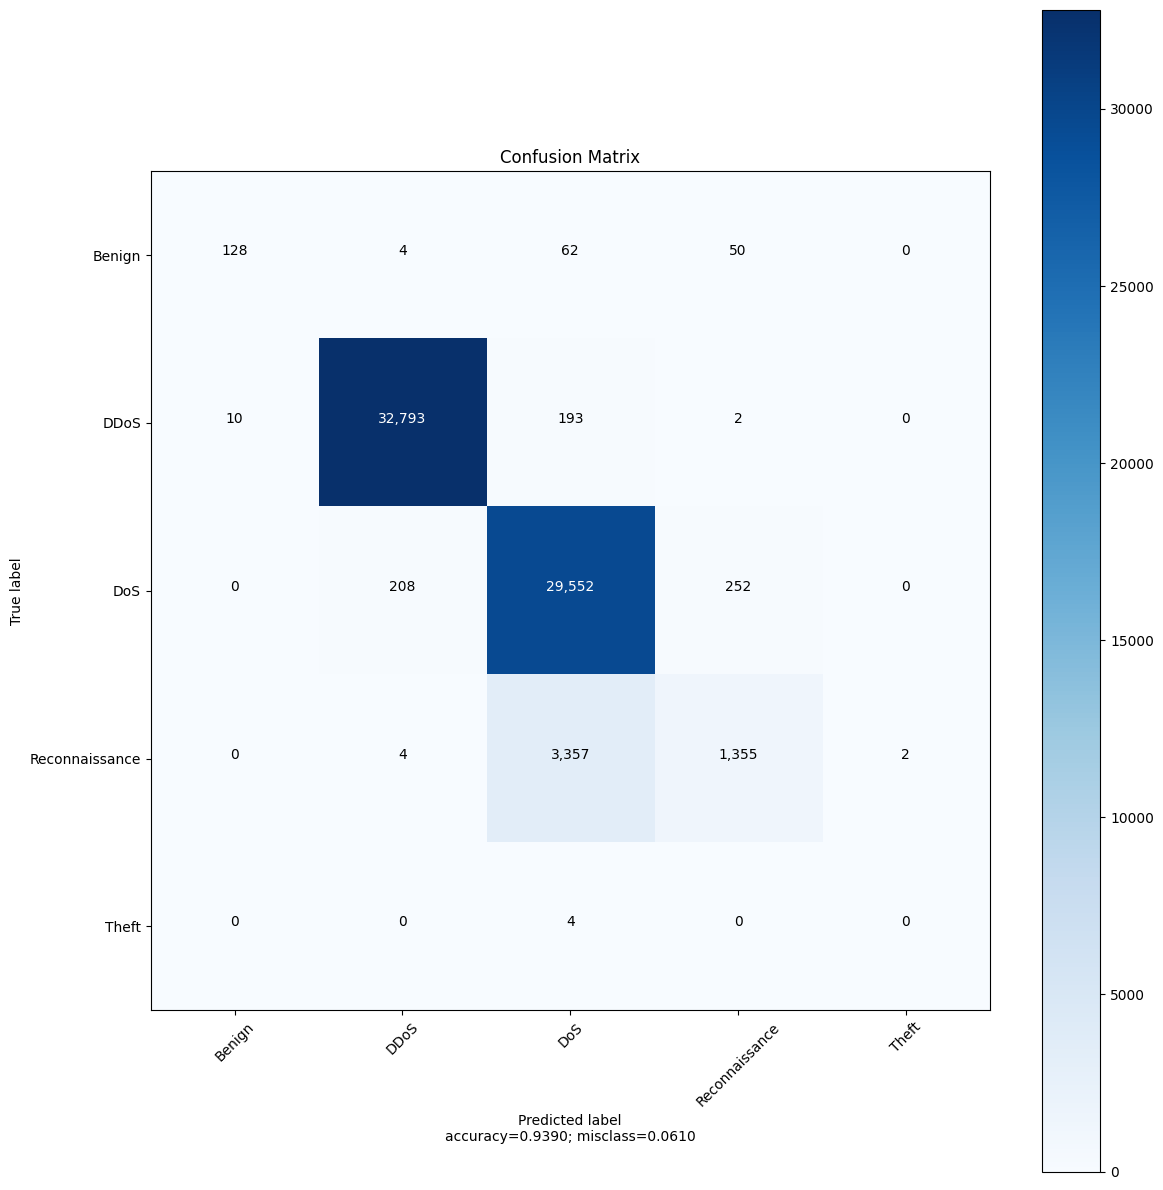

In [27]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(test_lbls, preds), 
                      normalize    = False,
                      target_names = np.unique(test_lbls),
                      title        = "Confusion Matrix")

In [28]:
test_lbls = list(test_lbls)
preds = list(preds)

In [29]:
from sklearn.metrics import classification_report
target_names = np.unique(test_lbls)
print(classification_report(test_lbls, preds, target_names=target_names, digits=4))

                precision    recall  f1-score   support

        Benign     0.9275    0.5246    0.6702       244
          DDoS     0.9935    0.9938    0.9936     32998
           DoS     0.8910    0.9847    0.9355     30012
Reconnaissance     0.8168    0.2872    0.4250      4718
         Theft     0.0000    0.0000    0.0000         4

      accuracy                         0.9390     67976
     macro avg     0.7257    0.5580    0.6048     67976
  weighted avg     0.9357    0.9390    0.9273     67976

